<a href="https://colab.research.google.com/github/Merchan00/UndergraduateResearchWork/blob/main/z_R_10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Drive

In [ ]:
#drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D
from tensorflow.keras.models import Model
import tensorflow as tf

width_shape, height_shape = 128, 128 # Tamaño de las imagenes de entrada
batch_size = 16
epochs = 50

MessageError: ignored

# Funciones

In [ ]:
valor=0

def umbral(img):
    aux=[]
    n,m,_=img.shape
    for i in range(n):
        for j in range(m):
            valu=img[i,j]
            if valu>0:
                aux.append(valu)

    va=np.mean(aux)
    return va

def umbral2(img,um):
    n,m,_=img.shape
    aux=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            valor=img[i,j]
            if valor>um:
                aux[i,j]=1
            else:
                pass

    return aux

def gris(img):
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    aux=imgGray
    
    return aux

def Valid(Xtrain):
    train_size=0.8
    f=len(Xtrain)
    #print("oper: ",f*train_size)
    if (f*train_size).is_integer()==True:   
        valor=len(Xtrain)
    else:      
        valor=f-1
        #print("valor: ",valor)
        Xtrain=Xtrain[:valor]
        Valid(Xtrain)
    
    return valor        

def loaddata(data_list_train):

    Xtrain=[] 
    Ytrain=[]
    Xtest=[]

    # Recorremos la carpeta train
    for folder in tqdm(data_list_train):
    #for i in range(10):
        #folder=data_list_train[i]
        try:    
            # leemos cada imagen del dataset de entrenamiento y la redimensionamos
            name=data_path_train +"/"+folder+ '/image/' + folder+'.png'
            img = imread(name)[:,:,:3]  
            #img = gris(img)
            img = resize(img, (height_shape, width_shape),mode='constant', preserve_range=True)
            #img = img[:,:,None]
            # Agregamos cada imagen a la lista Xtrain
            if np.any(img)==True:
                Xtrain.append(img)
                #print("archivo:"+name)
                mask = data_path_train +"/"+folder+ '/masks/' + folder+'_mask.png'
                img2 = imread(mask)[:,:,:3]  
                img2 = gris(img2)
                img2 = resize(img2,(height_shape, width_shape),mode='constant', preserve_range=True)
                aux = img2[:,:,None] 
                val = umbral(aux)
                img2 = umbral2(aux,val)
                img2 = img2[:,:,None] 
                # Agregamos cada mascara a la lista Ytrain
                Ytrain.append(img2)
        except:
            pass

        #data_list_train = data_list_train1

    #print(len(Xtrain))
    #print("-----------")
    from sklearn.model_selection import train_test_split

    numero=Valid(Xtrain)
    X_train, X_test, Y_train, Y_test = train_test_split(Xtrain[:numero],Ytrain[:numero],random_state=104, train_size=0.8, shuffle=True)
    print("\n")
    X_train = np.asarray(X_train,dtype=np.float32)
    print('Xtrain:',X_train.shape)
    Y_train = np.asarray(Y_train,dtype=np.float32)
    print('Ytrain:',Y_train.shape)
    X_test = np.asarray(X_test,dtype=np.float32)
    print('Xtest:',X_test.shape)
    Y_test = np.asarray(Y_test,dtype=np.float32)
    print('Ytest:',Y_test.shape)
    X_train /=255
    #Y_train /=255
    X_test /=255
    #Y_test /=255

    return X_train,Y_train,X_test,Y_test


def gra_train(results):
    #results.history to see all keys 
    preci = results.history['precision']
    val_preci = results.history['val_precision']

    re_call = results.history['recall']
    val_re_call = results.history['val_recall']

    loss = results.history['loss']
    val_loss = results.history['val_loss']

    epochs_range = range(len(preci))

    fig, axs = plt.subplots(1,3, figsize=(20, 20))
    fig.suptitle("Metrics", fontsize=15)

    #Precision
    axs[0].plot(epochs_range, preci, label='Training Precision')
    axs[0].plot(epochs_range, val_preci, label='Validation Precision')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Training and Validation Precision')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Value')
    fig.suptitle("Metrics", fontsize=15)

    #Recall
    axs[1].plot(epochs_range, re_call, label='Training Recall')
    axs[1].plot(epochs_range, val_re_call, label='Validation Recall')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Training and Validation Recall')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Value')
    fig.suptitle("Metrics", fontsize=15)

    #loss
    axs[2].plot(epochs_range, loss, label='Training Loss')
    axs[2].plot(epochs_range,  val_loss, label='Validation Loss')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Training and Validation Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Value')

def plot_predict(image,predict,test):    
    fig, axs = plt.subplots(1,3,figsize=(20, 20) )
    axs = axs.flatten()

    axs[0].imshow(image, cmap="gray")
    axs[0].set_axis_off()
    axs[0].set_title('Image')
    
    axs[1].imshow(predict, cmap="gray")
    axs[1].set_axis_off()
    axs[1].set_title('Predict')

    axs[2].imshow(test, cmap="gray")
    axs[2].set_axis_off()
    axs[2].set_title('Label')

def dice_coefficient(img1, img2):
    intersection = np.sum(np.logical_and(img1, img2))
    union = np.sum(np.logical_or(img1, img2))
    coefficient = 2 * intersection / (union + intersection)
    return coefficient


# Cargar datos y modelo

In [ ]:
#datos
data_path_train="/content/drive/MyDrive/Trabajo_de_Grado/Pulmonary/DATA_w_mask/train"
data_path_test="/content/drive/MyDrive/Trabajo_de_Grado/Pulmonary/DATA_w_mask/test"
data_list_train = os.listdir(data_path_train)
data_list_test = os.listdir(data_path_test)

data_list_train2=data_list_train[:11000]
X_train,Y_train,X_test,Y_test=loaddata(data_list_train2)

  1%|          | 109/11000 [00:09<16:16, 11.16it/s]/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 11000/11000 [15:47<00:00, 11.61it/s]




Xtrain: (8448, 128, 128, 3)
Ytrain: (8448, 128, 128, 1)
Xtest: (2112, 128, 128, 3)
Ytest: (2112, 128, 128, 1)


In [ ]:
#modelo
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/Trabajo_de_Grado/Pulmonary/FASES/FASE_III/FINALDELOSFINALES/Results/10k/RED_ANET.h5', compile=False)

gg=len(my_model.layers)
for layer in my_model.layers[:gg]:
    layer.trainable = False

model2 = tf.keras.models.Sequential()
model2.add(my_model)

model2.compile(optimizer='adam', 
                loss=['binary_crossentropy'], 
                metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Resultados visuales

66/66 [==============================] - 15s 223ms/step


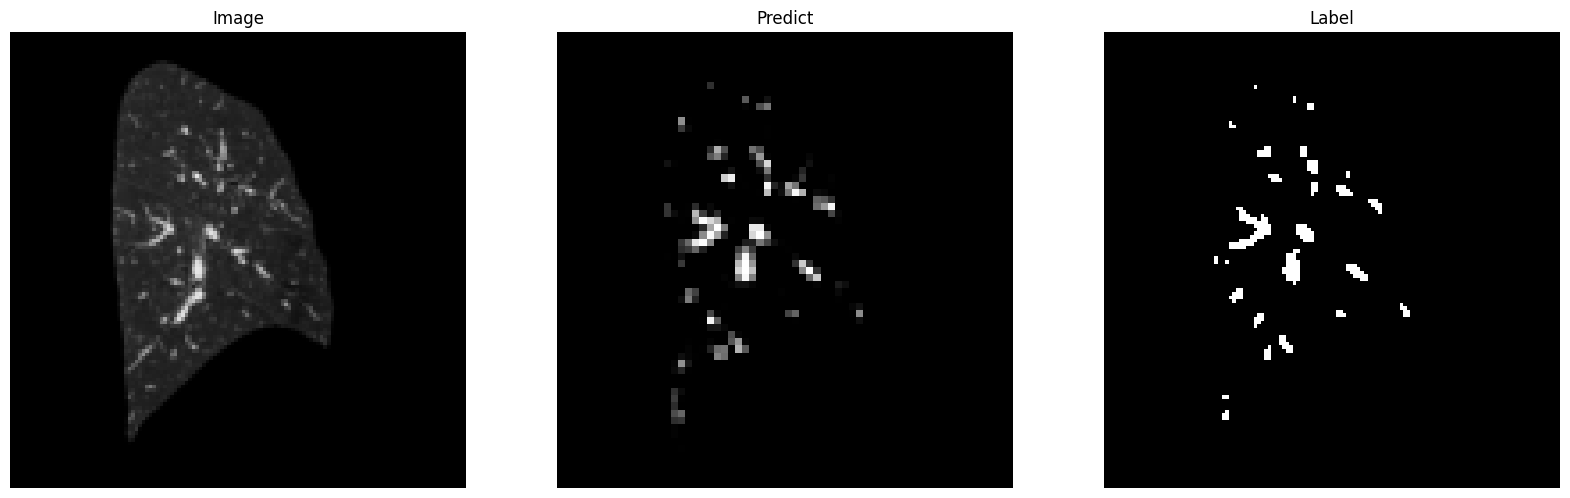

In [ ]:
preds_test2 = model2.predict(X_test, verbose=1)

preds_test_t3 = (preds_test2)
plot_predict(X_test[1120],preds_test_t3[1120],Y_test[1120])

Coeff dice: 0.7104377104377104


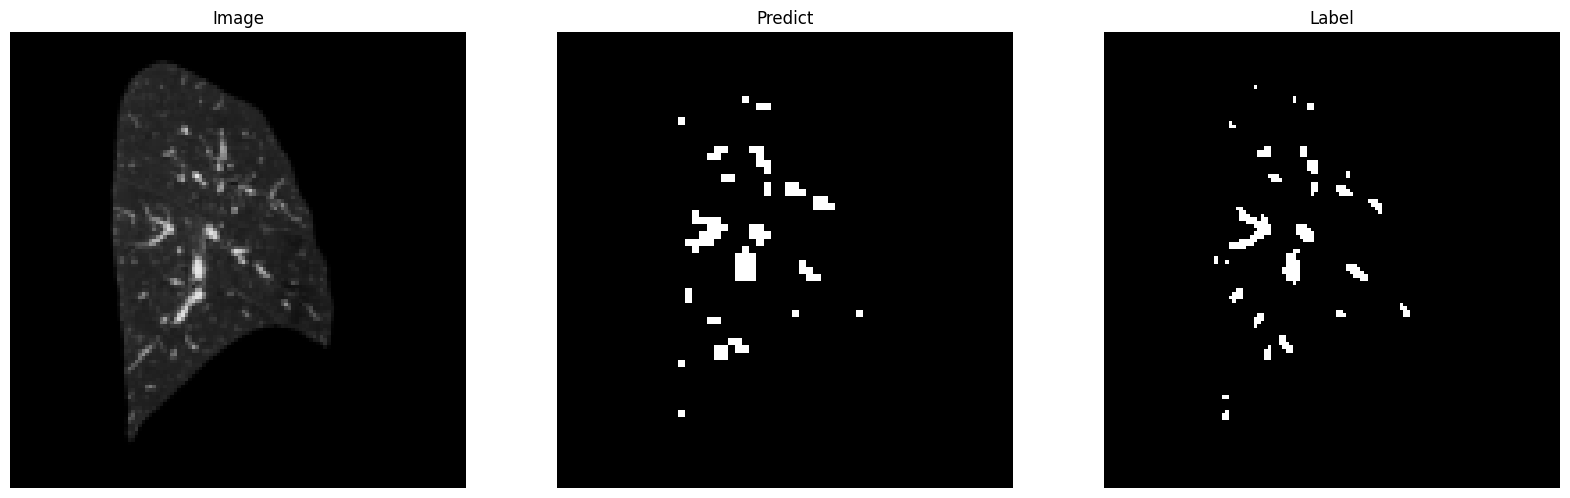

In [ ]:
#Aqui se cargar las anotaciones de test y se umbralizan
dd=1120
preds_test_t5 = (preds_test2)
pred_img=preds_test_t5[dd]
val=umbral(pred_img)
pred_img2=umbral2(pred_img,val)
pred_img2=pred_img2[:,:,]

OL2=preds_test_t5[dd]
OL2=OL2>0.3
img_test=(Y_test)
img_test2=img_test[dd]

test_img=X_test[dd]
plot_predict(test_img,OL2,img_test2)
print("Coeff dice:",dice_coefficient(OL2,img_test2))

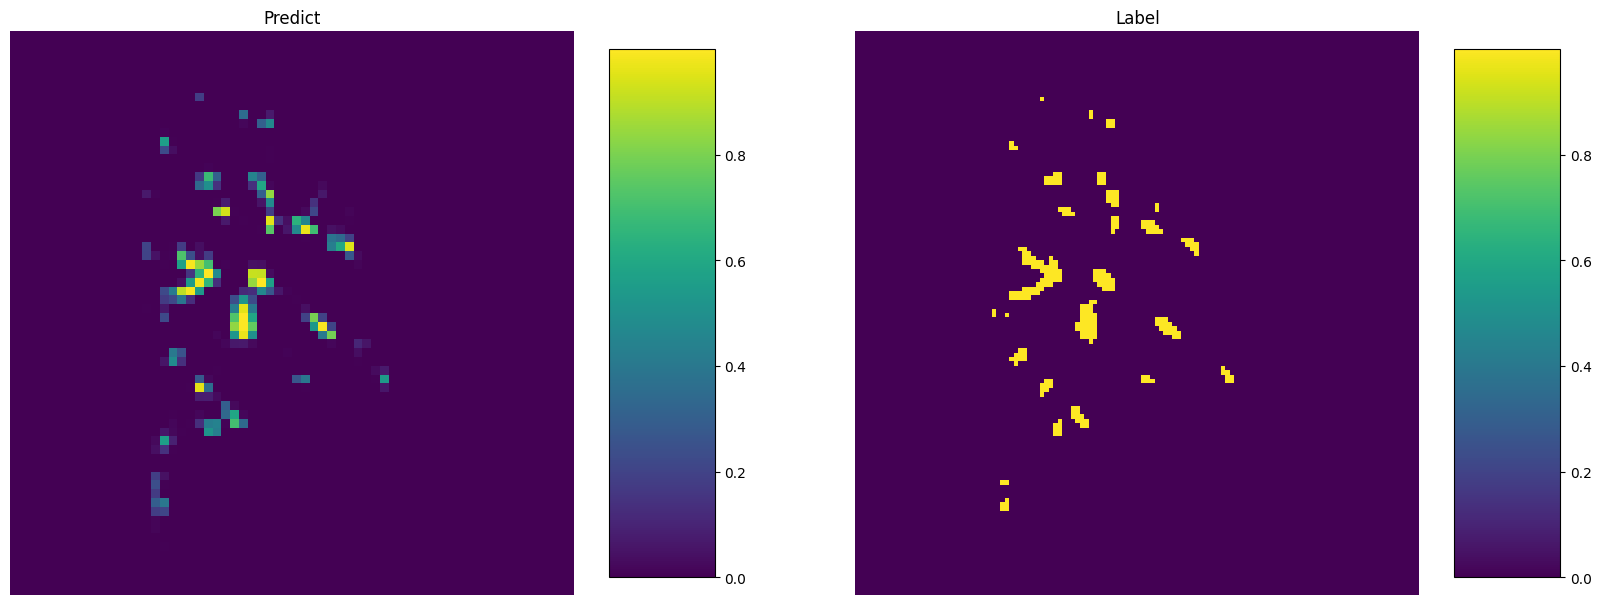

In [ ]:
import matplotlib as mpl

cmap = mpl.cm.cool
#plt.imshow(OL[1120],cmap=cmap)

fig, axs = plt.subplots(1,2,figsize=(20, 20) )
axs = axs.flatten()

a1=axs[0].imshow(pred_img)
axs[0].set_axis_off()
axs[0].set_title('Predict')
plt.colorbar(a1,ax=axs[0],aspect=5)

a2=axs[1].imshow(img_test2)
axs[1].set_axis_off()
axs[1].set_title('Label')
plt.colorbar(a1,ax=axs[1],aspect=5)

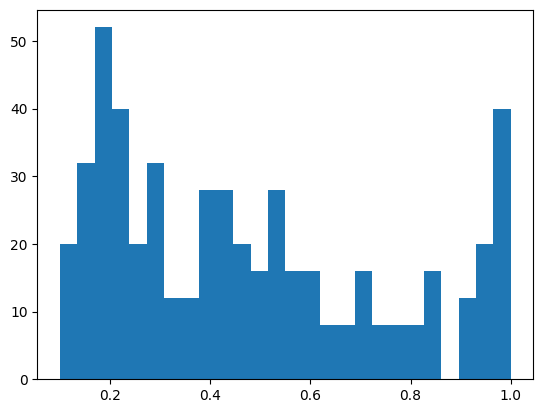

In [ ]:
hist=plt.hist(pred_img.ravel(), range=(0.1, 1.0),bins=26) 

In [ ]:
def sel(img,min,max):
  n,m,k=img.shape
  aux=np.zeros((n,m))
  for i in range(n):
    for j in range(m):
      pix=img[i,j]
      if pix>min and pix<max:
        pix=1
        aux[i,j]=pix

  return aux

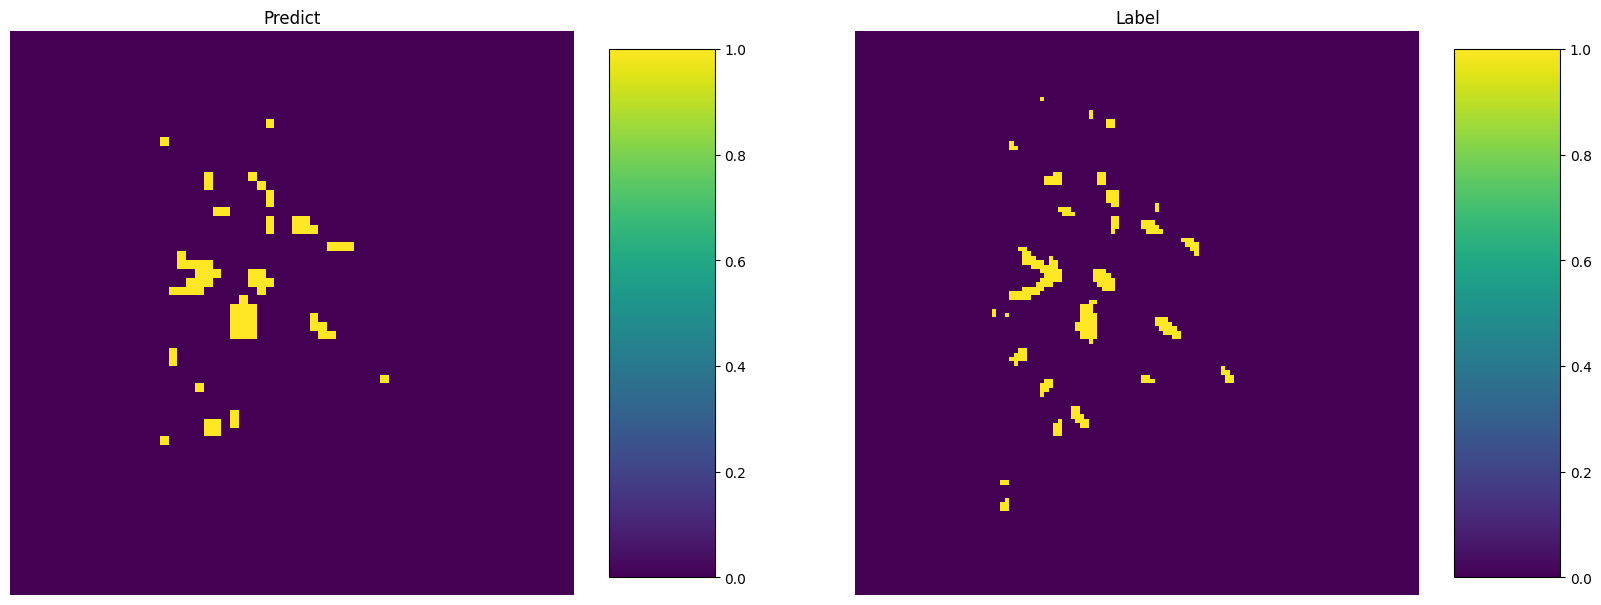

In [ ]:
import matplotlib as mpl

cmap = mpl.cm.cool
#plt.imshow(OL[1120],cmap=cmap)
gh=sel(pred_img,0.4,1)

fig, axs = plt.subplots(1,2,figsize=(20, 20) )
axs = axs.flatten()

a1=axs[0].imshow(gh)
axs[0].set_axis_off()
axs[0].set_title('Predict')
plt.colorbar(a1,ax=axs[0],aspect=5)

a2=axs[1].imshow(img_test2)
axs[1].set_axis_off()
axs[1].set_title('Label')
plt.colorbar(a1,ax=axs[1],aspect=5)

# Resultados de test


<ipython-input-17-762321c464ed>:169: RuntimeWarning: invalid value encountered in scalar divide
  coefficient = 2 * intersection / (union + intersection)


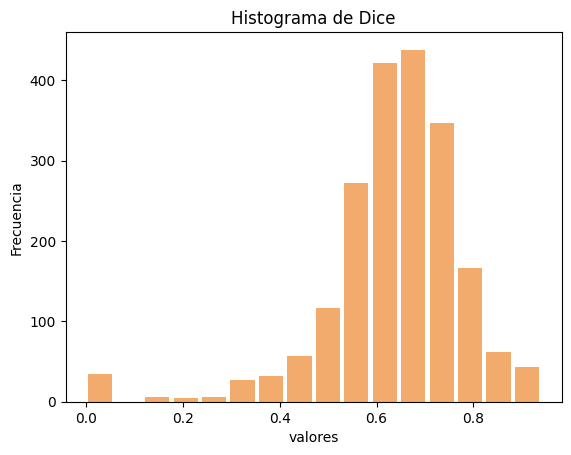

0.6363626387347222


In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plot

Dice=[]
valores_dice=[]

preds_test3=preds_test2>0.3
for i in range(int(X_test.shape[0])):
    nu=dice_coefficient(preds_test3[i],img_test[i])
    if math.isnan(nu):
        Dice.append('')
    else:
        Dice.append(nu)


data=pd.DataFrame(Dice)
headlist=["Valor"]
data.columns=headlist
data.drop(data[  (data['Valor'] =='') ].index, inplace=True)
valores_dice=data["Valor"]

plot.hist(x=valores_dice, bins=16, color='#F2AB6D', rwidth=0.85)
plot.title('Histograma de Dice')
plot.xlabel('valores')
plot.ylabel('Frecuencia')

plot.show()

print(np.mean(valores_dice))

<ipython-input-17-762321c464ed>:169: RuntimeWarning: invalid value encountered in scalar divide
  coefficient = 2 * intersection / (union + intersection)


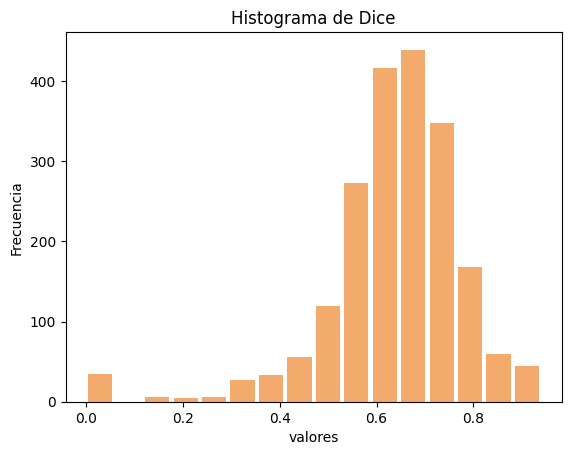

0.6364495941796368


In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plot

Dice=[]
valores_dice=[]

preds_test3=preds_test2>0.303333
for i in range(int(X_test.shape[0])):
    nu=dice_coefficient(preds_test3[i],img_test[i])
    if math.isnan(nu):
        Dice.append('')
    else:
        Dice.append(nu)


data=pd.DataFrame(Dice)
headlist=["Valor"]
data.columns=headlist
data.drop(data[  (data['Valor'] =='') ].index, inplace=True)
valores_dice=data["Valor"]

plot.hist(x=valores_dice, bins=16, color='#F2AB6D', rwidth=0.85)
plot.title('Histograma de Dice')
plot.xlabel('valores')
plot.ylabel('Frecuencia')

plot.show()

print(np.mean(valores_dice))

<ipython-input-17-762321c464ed>:169: RuntimeWarning: invalid value encountered in scalar divide
  coefficient = 2 * intersection / (union + intersection)


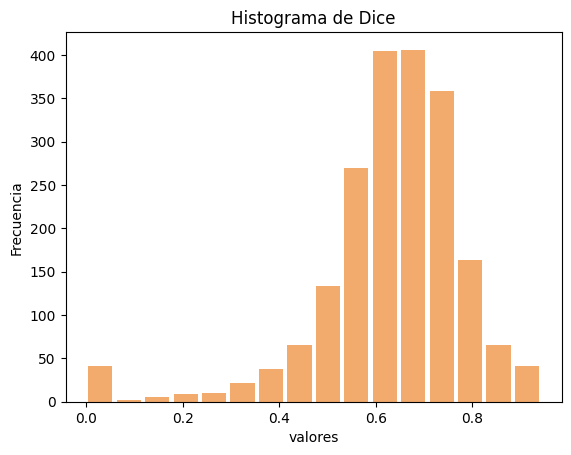

0.6320352257395901


In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plot

Dice=[]
valores_dice=[]

preds_test3=preds_test2>0.35
for i in range(int(X_test.shape[0])):
    nu=dice_coefficient(preds_test3[i],img_test[i])
    if math.isnan(nu):
        Dice.append('')
    else:
        Dice.append(nu)


data=pd.DataFrame(Dice)
headlist=["Valor"]
data.columns=headlist
data.drop(data[  (data['Valor'] =='') ].index, inplace=True)
valores_dice=data["Valor"]

plot.hist(x=valores_dice, bins=16, color='#F2AB6D', rwidth=0.85)
plot.title('Histograma de Dice')
plot.xlabel('valores')
plot.ylabel('Frecuencia')

plot.show()

print(np.mean(valores_dice))

#Umbral

In [ ]:
def umbral(img):
    aux=[]
    n,m,k=img.shape
    for i in range(n):
        for j in range(m):
            valu=img[i,j]
            if valu>0:
                aux.append(valu)

    va=np.mean(aux)
    return va

In [ ]:
len(PP)

2000

In [ ]:
PP[1].shape

(128, 128, 1)

In [ ]:
PP=preds_test2
PP2=preds_test2
gg=[]

for i in range(len(PP)):
    PP2[i]=PP[i]>umbral(PP[i])

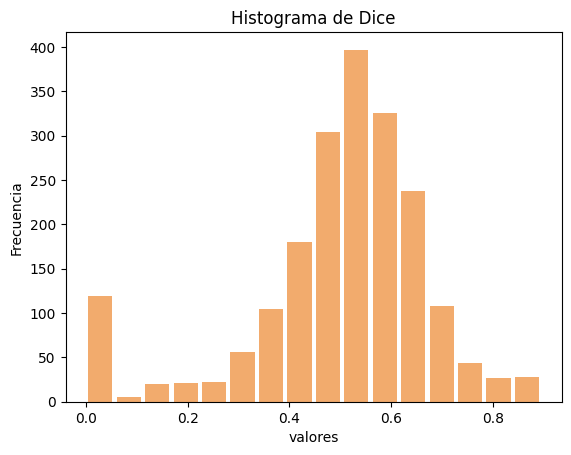

0.4993764486380696


In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plot

Dice=[]
valores_dice=[]

preds_test3=PP2
for i in range(int(X_test.shape[0])):
    nu=dice_coefficient(preds_test3[i],img_test[i])
    if math.isnan(nu):
        Dice.append('')
    else:
        Dice.append(nu)


data=pd.DataFrame(Dice)
headlist=["Valor"]
data.columns=headlist
data.drop(data[  (data['Valor'] =='') ].index, inplace=True)
valores_dice=data["Valor"]

plot.hist(x=valores_dice, bins=16, color='#F2AB6D', rwidth=0.85)
plot.title('Histograma de Dice')
plot.xlabel('valores')
plot.ylabel('Frecuencia')

plot.show()

print(np.mean(valores_dice))

# Umbral v2


In [ ]:
hist, bins = np.histogram(pred_img, bins=16, range=(0.1, 1), density=True)

kernel = np.ones(5)/5
hist_smoothed = np.convolve(hist, kernel, mode='same')

# Encontrar el valor de intensidad correspondiente al pico del histograma
threshold = bins[np.argmax(hist_smoothed)]
threshold2 = bins[np.argmin(hist_smoothed)]
print(threshold2)

0.71875


In [ ]:
var = np.var(pred_img)

print("La varianza de la imagen es:", var)

std = np.std(pred_img)

print("La desviación estándar de la imagen es:", std)

La varianza de la imagen es: 0.009283049
La desviación estándar de la imagen es: 0.09634858


In [ ]:
U=2.5*std+var

In [ ]:
U

0.32804040145128965

# Resultados formula umbral


In [ ]:
def valorU(img):
    var = np.var(img)
    std = np.std(img)
    return (var/std)+2*std

In [ ]:
preds_test2 = model2.predict(X_test, verbose=1)
PP=preds_test2
PP2=preds_test2
gg=[]

for i in range(len(PP)):
    PP2[i]=PP[i]>valorU(PP[i])

66/66 [==============================] - 14s 219ms/step


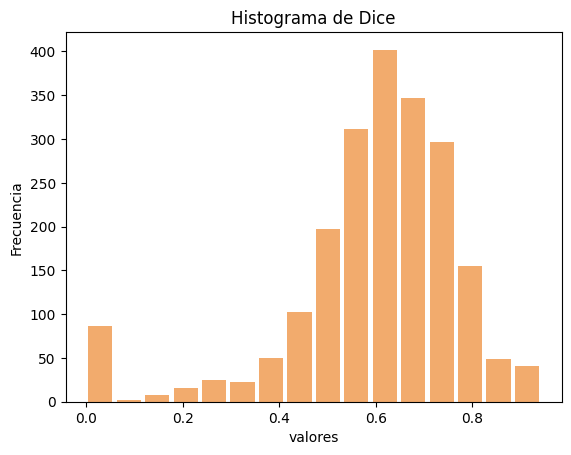

0.5979662917247773


In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plot

Dice=[]
valores_dice=[]
img_test=(Y_test)
preds_test3=PP2
for i in range(int(X_test.shape[0])):
    nu=dice_coefficient(preds_test3[i],img_test[i])
    if math.isnan(nu):
        Dice.append('')
    else:
        Dice.append(nu)


data=pd.DataFrame(Dice)
headlist=["Valor"]
data.columns=headlist
data.drop(data[  (data['Valor'] =='') ].index, inplace=True)
valores_dice=data["Valor"]

plot.hist(x=valores_dice, bins=16, color='#F2AB6D', rwidth=0.85)
plot.title('Histograma de Dice')
plot.xlabel('valores')
plot.ylabel('Frecuencia')

plot.show()

print(np.mean(valores_dice))

In [ ]:
data

,Valor
0,0.651163
1,0.520833
2,0.806137
3,0.607595
4,0.475000
...,...
2107,0.487395
2108,0.767754
2109,0.562092
2110,0.880952


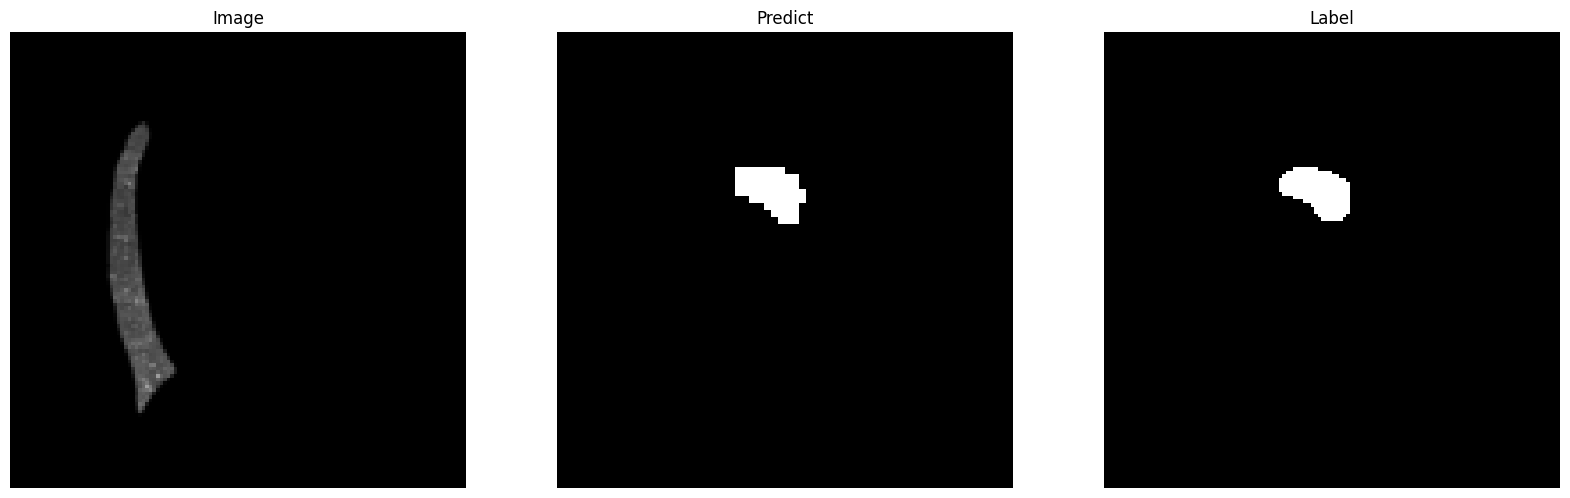

In [ ]:
uio=1417
plot_predict(X_test[uio],preds_test2[uio],Y_test[uio])

#Graficar todas

In [ ]:
len(X_test)

2112

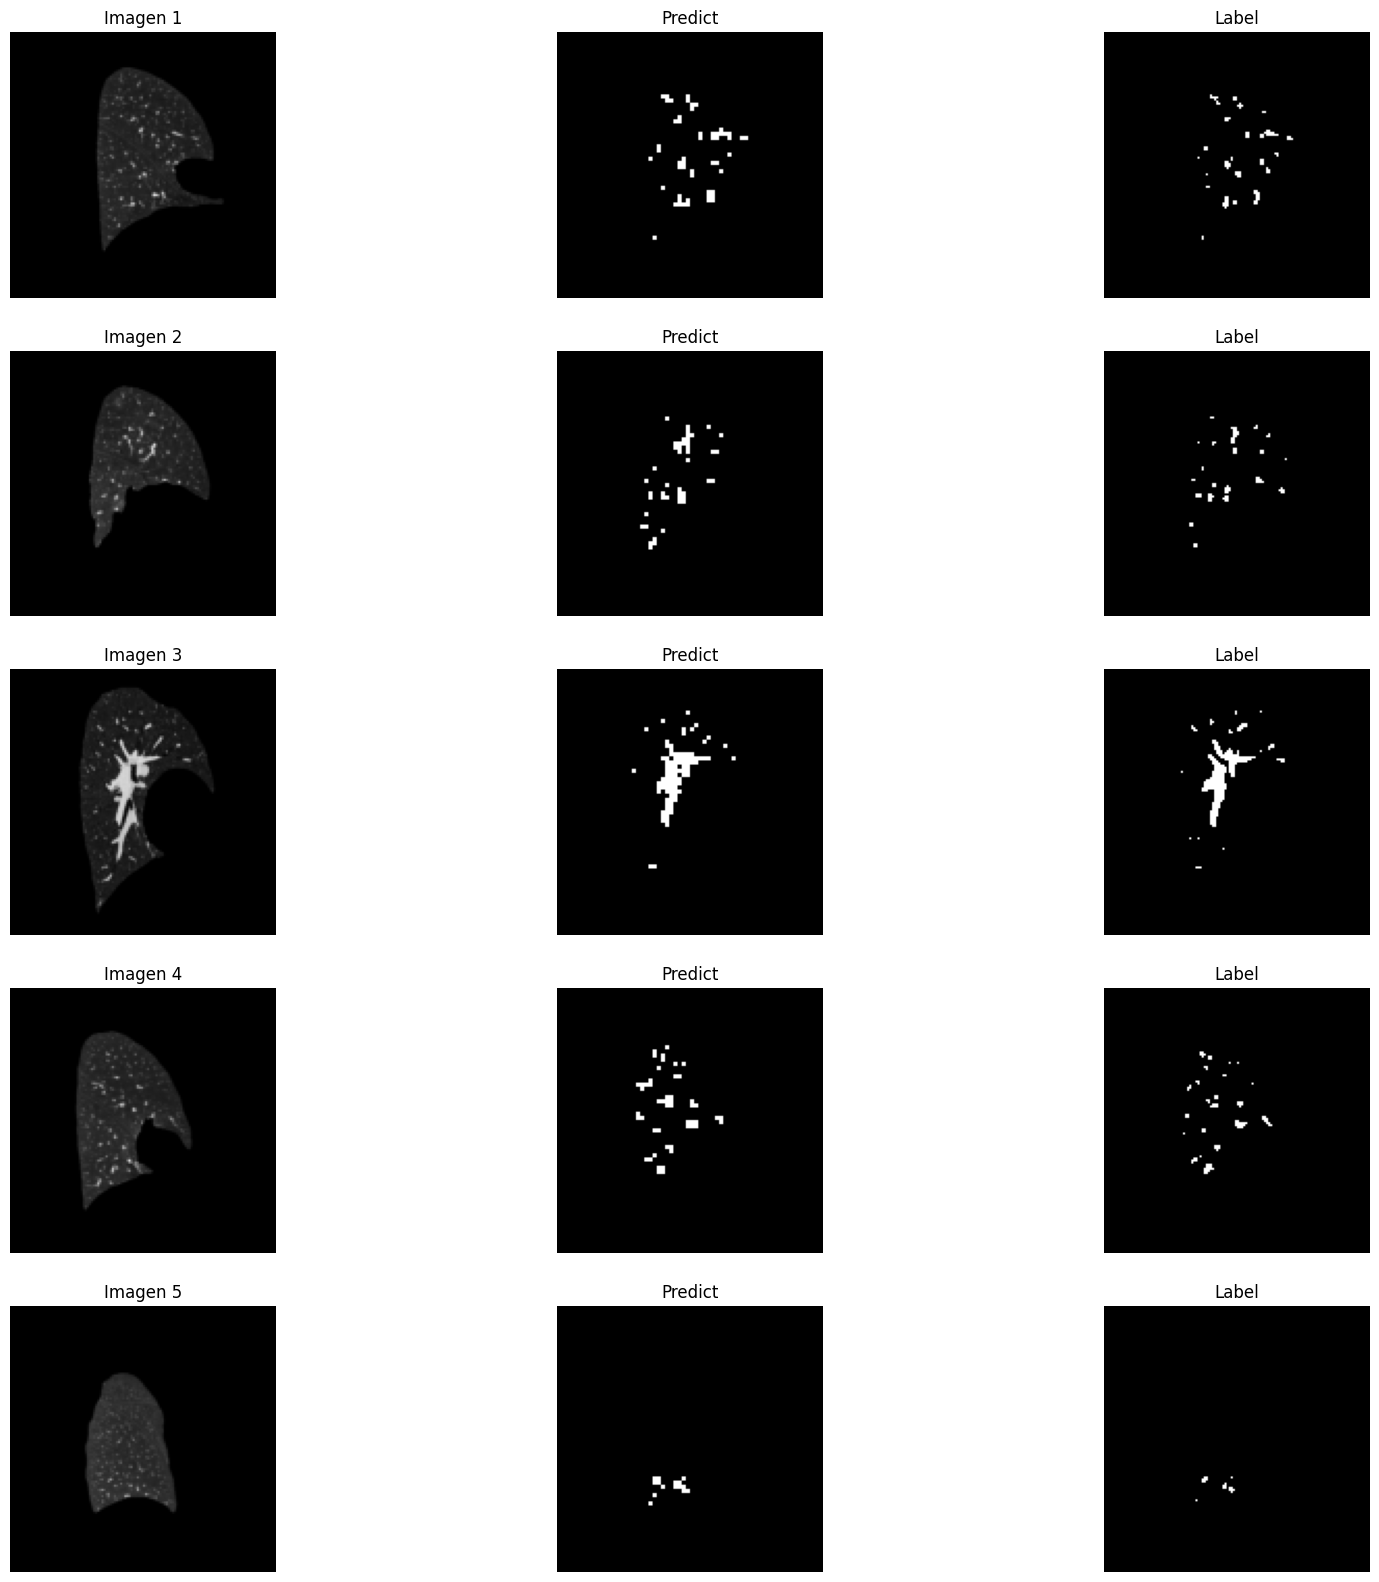

In [ ]:
n=5
fig, axs = plt.subplots(n, 3, figsize=(20, 20))

# Graficar cada imagen en los subplots
for i in range(n):
    axs[i, 0].imshow(X_test[i], cmap='gray')
    axs[i, 0].set_title('Imagen {}'.format(i+1))
    axs[i, 0].axis('off')

    axs[i, 1].imshow(preds_test2[i], cmap='gray')
    axs[i, 1].set_title('Predict')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(Y_test[i], cmap='gray')
    axs[i, 2].set_title('Label')
    axs[i, 2].axis('off')

# Ajustar los subplots y mostrar la figura
plt.show()